In [6]:
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
plt.rcParams['figure.figsize'] = 10, 10

import cartopy.crs as ccrs

from metpy.mapping import triangles, points, polygons
from metpy.mapping.tests.test_MPGridding import station_test_data

from metpy.mapping.map_functions import remove_nans_and_repeats

from scipy.spatial import Voronoi, Delaunay, ConvexHull

from matplotlib.delaunay.triangulate import Triangulation

from_proj = ccrs.Geodetic()
to_proj = ccrs.AlbersEqualArea(central_longitude=-97.0000, central_latitude=38.0000)

def plot_triangle(triangle):
    x = [triangle[0,0], triangle[1,0], triangle[2,0], triangle[0,0]]
    y = [triangle[0,1], triangle[1,1], triangle[2,1], triangle[0,1]]
    
    plt.plot(x, y, ":", linewidth=2)

def plot_voronoi_lines(vor):
    
    for simplex in vor.ridge_vertices:
        simplex = np.asarray(simplex)
        if np.all(simplex >= 0):
            plt.plot(vor.vertices[simplex, 0], vor.vertices[simplex, 1], 'k--')

In [13]:
xp, yp, variable = station_test_data("air_temperature", from_proj, to_proj)

xp, yp, variable = remove_nans_and_repeats(xp, yp, variable)

bbox = points.get_boundary_coords(xp, yp)

grid_x, grid_y = points.generate_grid(100000, bbox)

In [16]:
vor = Voronoi(pts, incremental=True)

t = Triangulation(xp, yp)

In [25]:
tri = Delaunay(list(zip(xp, yp)))

grid_points = points.generate_grid_coords(grid_x, grid_y)

members, triangle_info = triangles.find_natural_neighbors(tri, grid_points)

grid = 500

neighbors = members[grid]

img = np.empty(shape=(grid_points.shape[0]), dtype=variable.dtype)
img.fill(np.nan)

neighbors

[3, 12, 13, 53, 54]

<IPython.core.display.Javascript object>


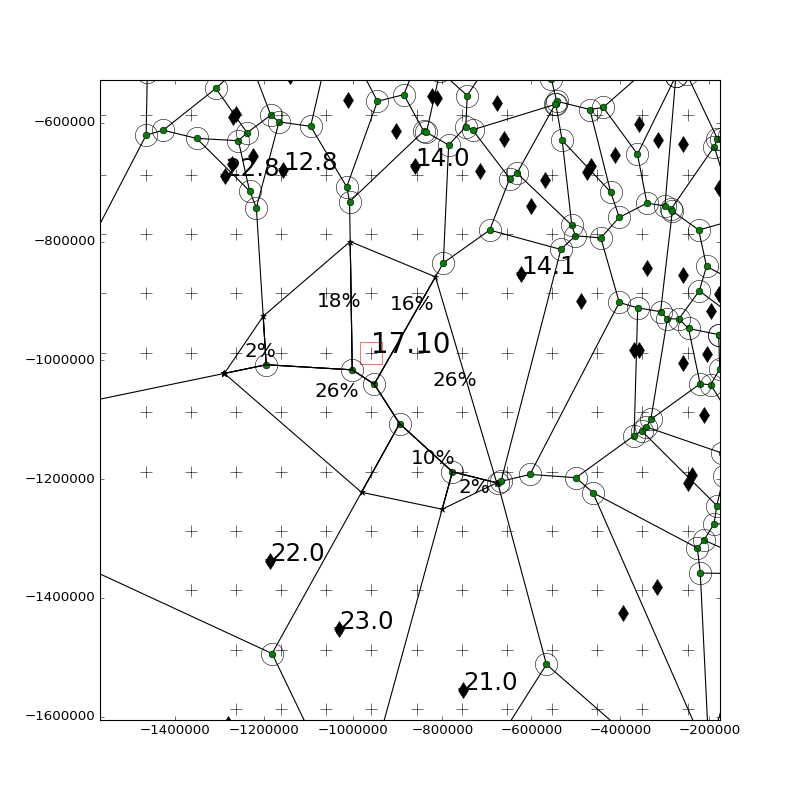

42511978525.5 22.0
16379524022.4 23.0
3351153691.97 21.0
43674535218.0 14.1
26694263119.3 14.0
29295853069.1 12.8
3894682839.28 22.8


In [26]:
from scipy.spatial import voronoi_plot_2d

voronoi_plot_2d(vor)

edges = triangles.find_local_boundary(tri, neighbors)

edge_vertices = [segment[0] for segment in polygons.order_edges(edges)]

polygon = list()

p1 = edge_vertices[0]
p2 = edge_vertices[1]

c1 = triangles.circumcenter(grid_points[grid], tri.points[p1], tri.points[p2])

polygon.append(c1)

edge_triangles = []

polygon_labels = []
area_list = []
num_vertices = len(edge_vertices)

total_area = 0.0

for i in range(num_vertices):

    p3 = edge_vertices[(i + 2) % num_vertices]

    c2 = triangles.circumcenter(grid_points[grid], tri.points[p3], tri.points[p2])

    polygon.append(c2)
    
    plt.plot(tri.points[p2][0], tri.points[p2][1], "r*", markersize=10)
    plt.plot([c1[0],c2[0]], [c1[1],c2[1]], 'k*')

    for check_tri in neighbors:
        if p2 in tri.simplices[check_tri]:
            polygon.append(triangle_info[check_tri]['cc'])

    poly_pts = np.array([polygon[i] for i in ConvexHull(polygon).vertices])
    poly_pts = np.concatenate((poly_pts, [poly_pts[0]]), axis=0)
    
    plt.plot(poly_pts[:,0], poly_pts[:,1], "k-") 
    
    value = variable[(tri.points[p2][0]==xp) & (tri.points[p2][1]==yp)][0]
    
    plt.annotate(str(value), xy=(tri.points[p2][0], tri.points[p2][1]), fontsize=22)    

    cur_area = polygons.area(poly_pts)
    total_area += cur_area

    area_list.append(cur_area * value)
    
    print(cur_area, value)
    
    x_temp = np.mean(poly_pts[:,0])
    y_temp = np.mean(poly_pts[:,1])

    polygon_labels.append((x_temp, y_temp, cur_area))
    
    polygon = list()
    polygon.append(c2)
    
    p1 = p2
    p2 = p3

interp_value = sum([x / total_area for x in area_list])

gps = grid_points[tri.find_simplex(grid_points) > 0]
plt.plot(gps[:,0], gps[:,1], 'k+', markersize=10)
plt.plot(grid_points[grid][0], grid_points[grid][1], "rs", markersize=20, fillstyle='none')

plt.annotate('{0:.2f}'.format(interp_value), xy=(grid_points[grid][0], grid_points[grid][1]), fontsize=25)

polygon_labels = np.array(polygon_labels)

for (x_t, y_t, val) in polygon_labels:
    
    plt.annotate("{0:.0f}%".format(100*val/total_area), xy=(x_t, y_t), fontsize=18)

plt.plot(xp, yp, "kd", markersize=10)

plt.xlim(-3000000, 3000000)
plt.ylim(-3000000, 3000000)

plt.plot(t.circumcenters[:,0], t.circumcenters[:,1], "ko", markersize=20, fillstyle='none')

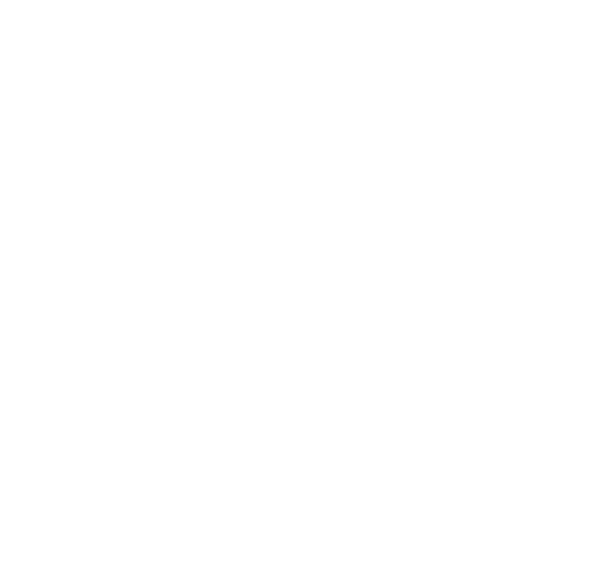

In [5]:
# Create an animation
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['animation.html'] = 'html5'
from matplotlib.animation import ArtistAnimation
from scipy.misc import imread
import glob

fig = plt.figure(figsize=(12, 8))


imgs = glob.glob("./nn_frames/*.jpg")

meshes = []

for file in imgs:
    img = imread(file)
    plt.axis('off')
    i = plt.imshow(img[50:-50,75:-75], animated=True)
    fig.tight_layout()
    meshes.append([i])

ArtistAnimation(fig, meshes, interval=500, repeat_delay=5000)